In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16


base_image_path='/content/cat2.png'

style_image_path = "/content/The_Great_Wave_off_Kanagawa.jpg"
prefix = "Cat_wave_16_500"

# Weights of loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimension Reduction
width, height = keras.preprocessing.image.load_img(base_image_path).size
rows = 400
cols = int(width * rows / height)


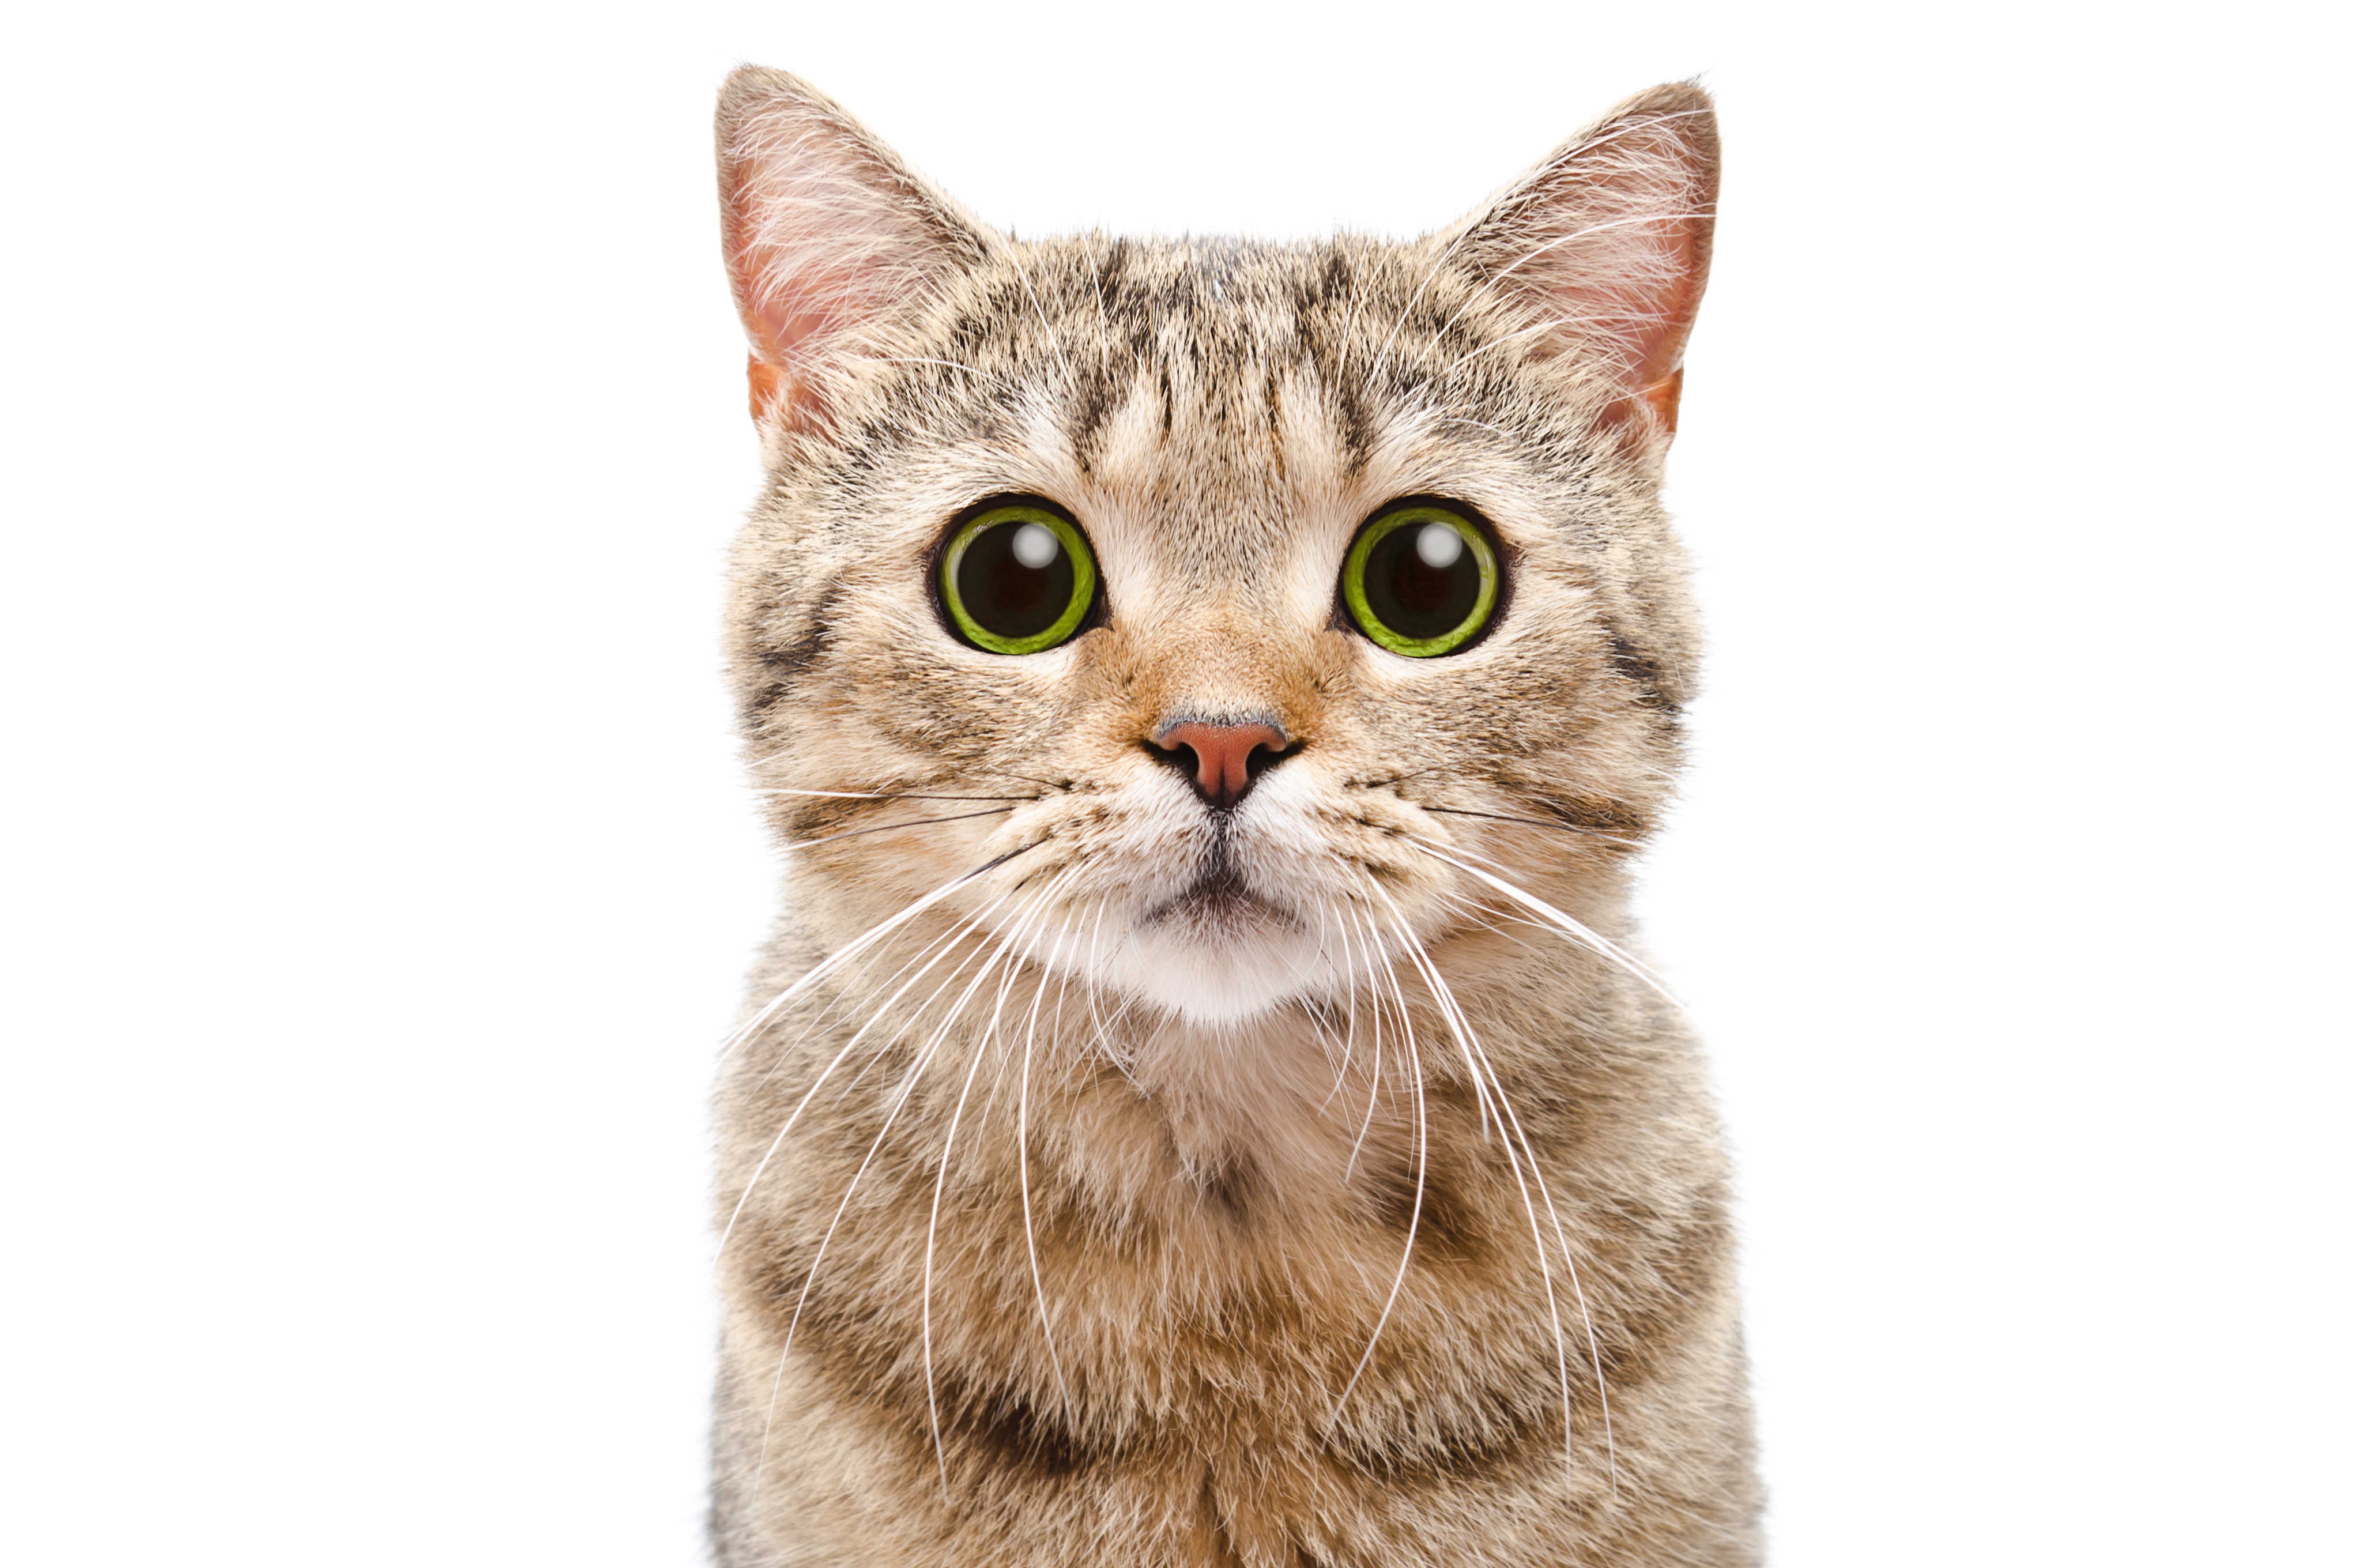

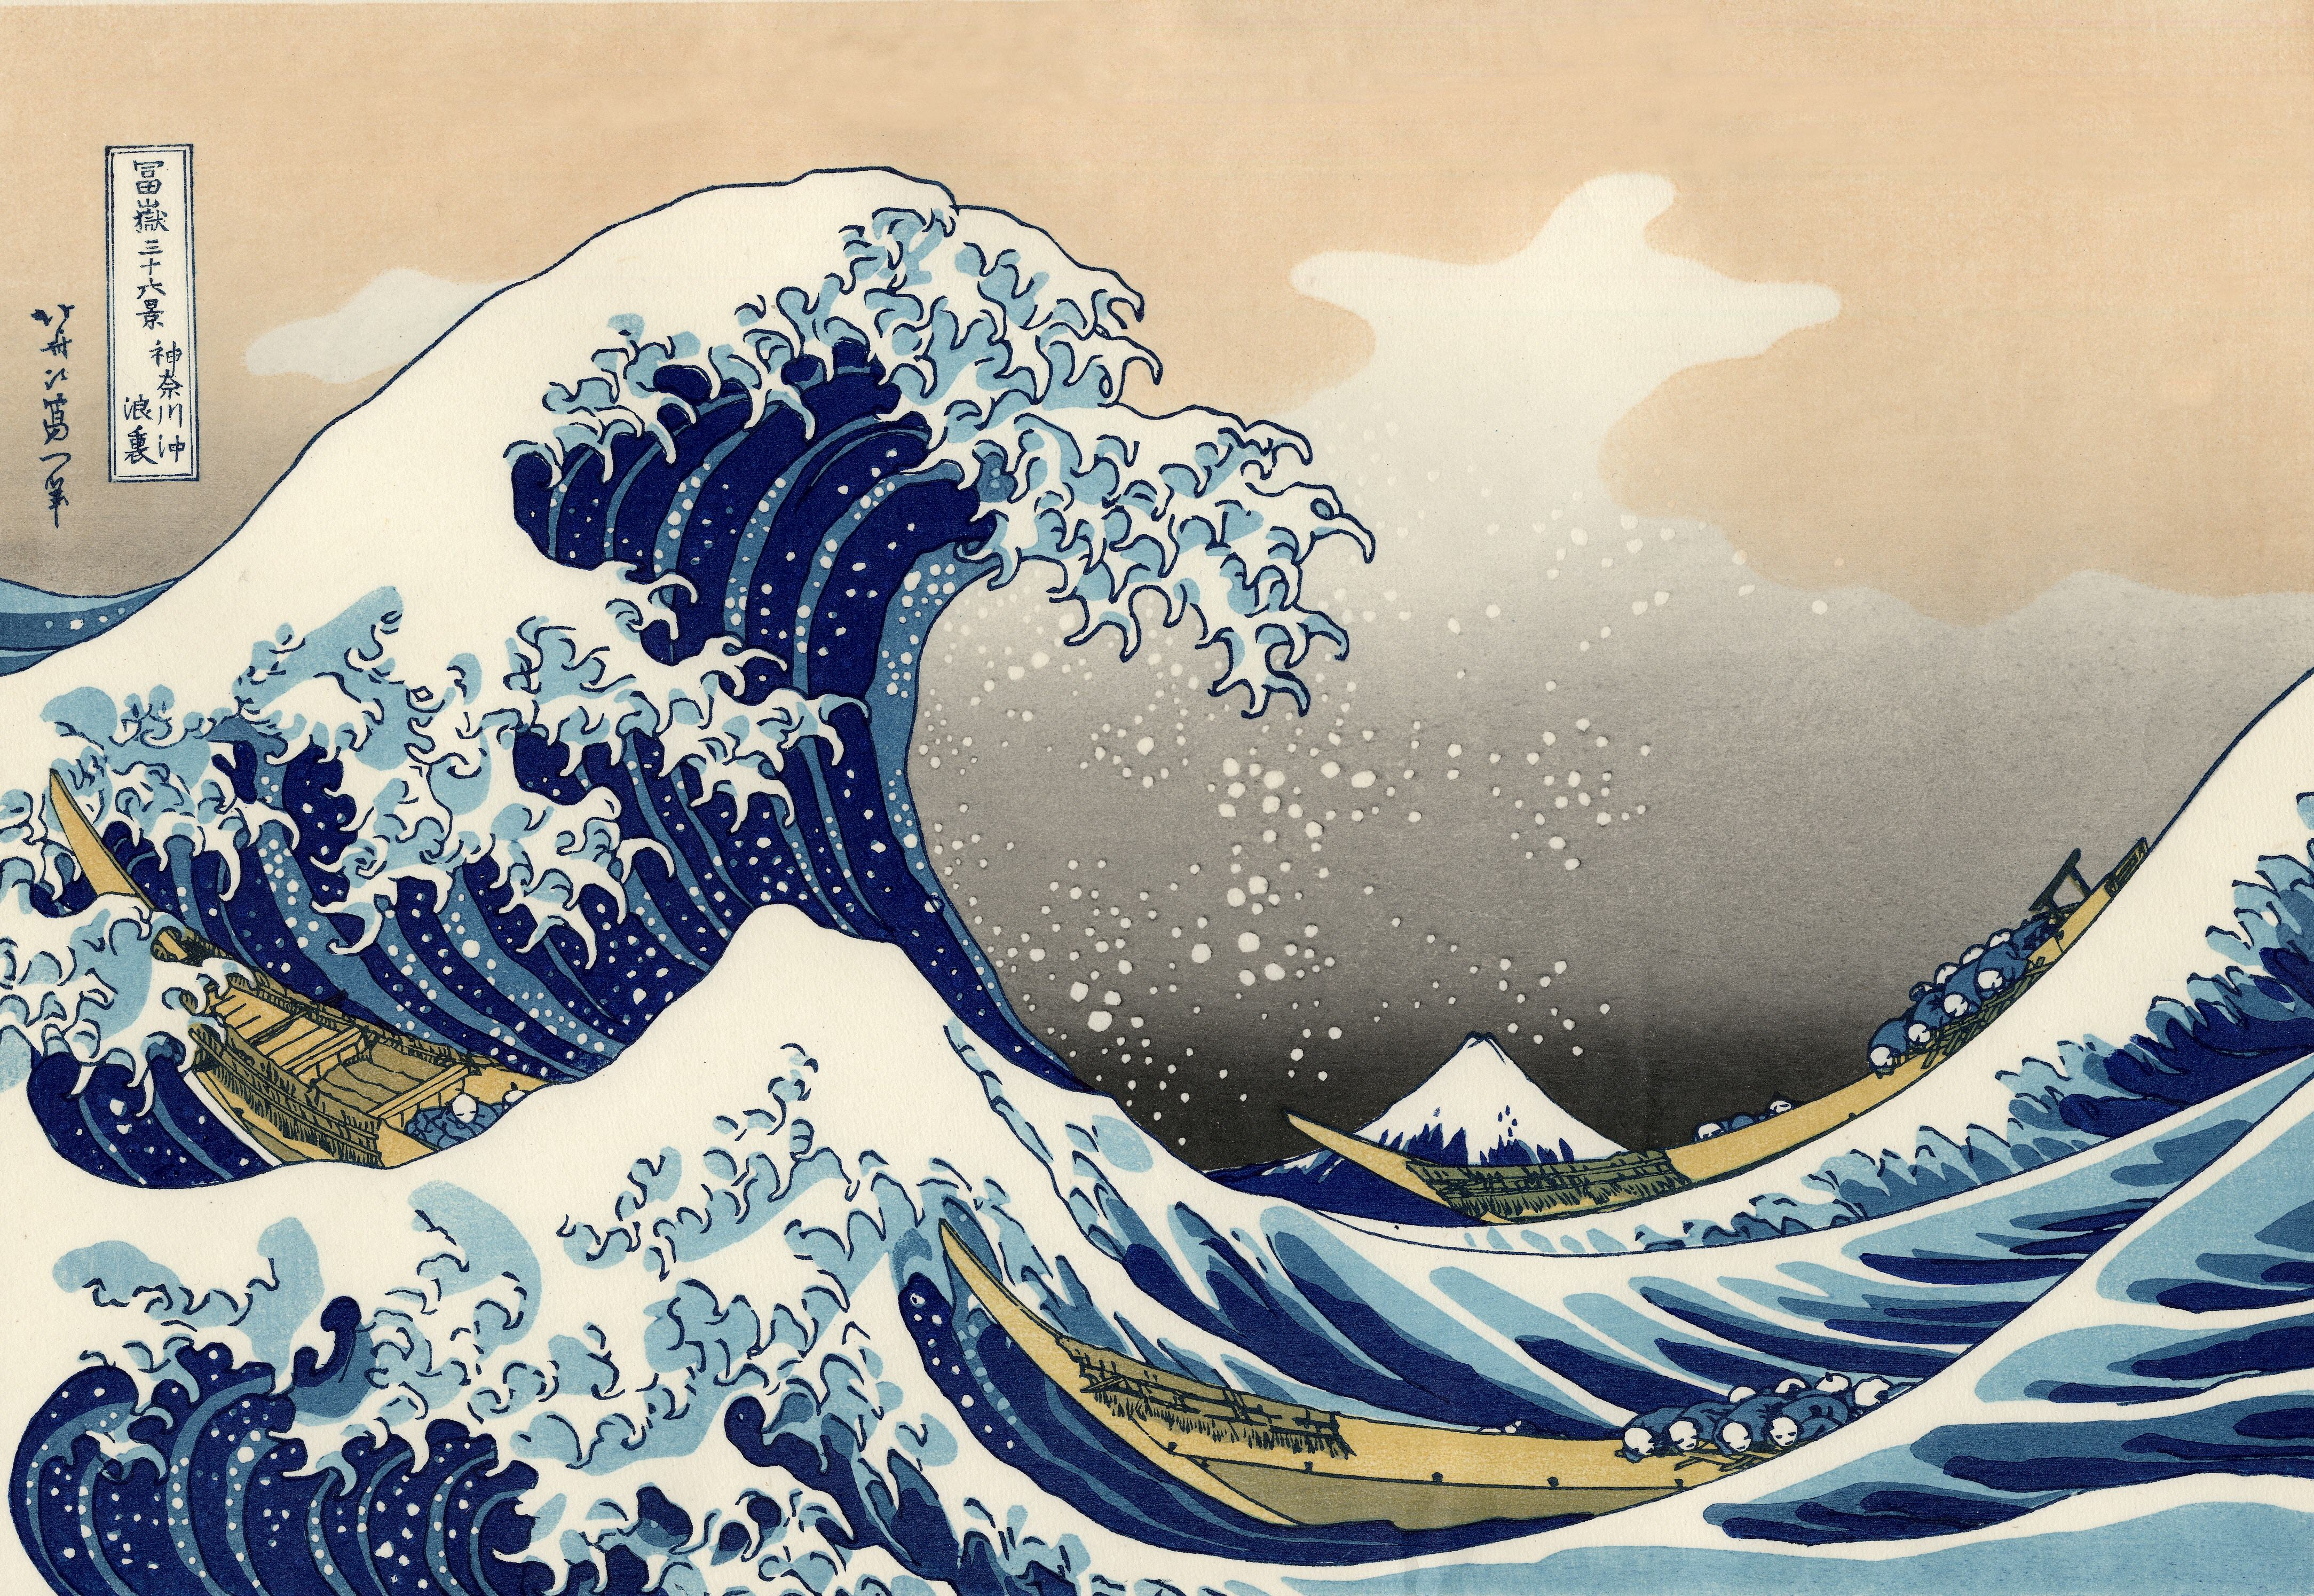

In [2]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_image_path))

In [3]:
def preprocess(image_path):
    #Format images into appropriate tensors
    image = keras.preprocessing.image.load_img(
        image_path, target_size=(rows, cols)
    )
    image = keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = vgg16.preprocess_input(image)
    return tf.convert_to_tensor(image)


def deprocess(ten_Img):
    # Deprocessig tensor back to image
    ten_Img = ten_Img.reshape((rows,cols, 3))
    # Remove zero-center by mean pixel
    ten_Img[:, :, 0] += 103.939
    ten_Img[:, :, 1] += 116.779
    ten_Img[:, :, 2] += 123.68
    # BGR to RGB
    ten_Img = ten_Img[:, :, ::-1]
    ten_Img = np.clip(ten_Img, 0, 255).astype("uint8")
    return ten_Img

In [4]:
#Defining the gram matrix
def gram_mat(input):
    input = tf.transpose(input, (2, 0, 1))
    features = tf.reshape(input, (tf.shape(input)[0], -1))
    gram_matrix = tf.matmul(features, tf.transpose(features))
    return gram_matrix


#Style Loss
def style_loss(style_img, combination_img):
    S = gram_mat(style_img)
    C = gram_mat(combination_img)
    channels = 3
    size = rows * cols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))




#Content Loss
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))



#Total Loss
def total_loss(In_Img):
    a = tf.square(
        In_Img[:, : rows - 1, : cols - 1, :] - In_Img[:, 1:, : cols - 1, :]
    )
    b = tf.square(
        In_Img[:, : rows - 1, : cols - 1, :] - In_Img[:, : rows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [5]:
#Model 
model = vgg16.VGG16(weights="imagenet", include_top=False)

# Symbolic outputs of each key layer
outputs_Key = dict([(layer.name, layer.output) for layer in model.layers])

# A model that returns the activation values for every layer in the Vgg Model
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_Key)

58892288/58889256 [==============================] - 0s 0us/step


In [6]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block4_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total  loss
    loss += total_variation_weight * total_loss(combination_image)
    return loss

In [7]:
@tf.function
def compute_loss_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [8]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess(base_image_path)
style_reference_image = preprocess(style_image_path)
combination_image = tf.Variable(preprocess(base_image_path))

iterations = 2000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess(combination_image.numpy())
        fname = prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
        

Iteration 100: loss=19283.94
Iteration 200: loss=16101.30
Iteration 300: loss=14793.80
Iteration 400: loss=14026.02
Iteration 500: loss=13503.83
Iteration 600: loss=13114.71
Iteration 700: loss=12809.85
Iteration 800: loss=12562.46
Iteration 900: loss=12356.79
Iteration 1000: loss=12181.12
Iteration 1100: loss=12029.52
Iteration 1200: loss=11897.61
Iteration 1300: loss=11781.25
Iteration 1400: loss=11677.42
Iteration 1500: loss=11584.26
Iteration 1600: loss=11499.94
Iteration 1700: loss=11423.53
Iteration 1800: loss=11354.40
Iteration 1900: loss=11291.20
Iteration 2000: loss=11233.19


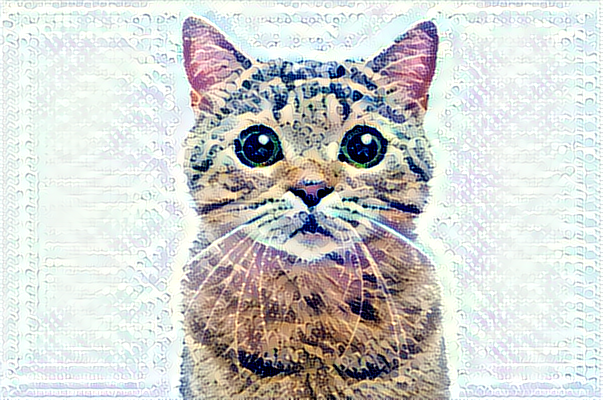

In [9]:
display(Image(prefix + "_at_iteration_2000.png"))
